# Transfer Learning Part 1: Feature Extraction

Transfer Learning is leavragin a working model exesting artitechture and learn pattrens for our problem.

There are Two main Benefits:
1. Can levrage our neural network architecture proven to work on problem similar to our own.
2. Can levrage a working nueral network architecture which has already learned patterns on similar data so we can adpat that pattren to our data


In [ ]:
!nvidia-smi

Mon Jul 11 05:05:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-11 05:05:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  64.4MB/s    in 2.5s    

2022-07-11 05:05:09 (64.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import zipfile
zipref = zipfile.ZipFile('/content/10_food_classes_10_percent.zip')
zipref.extractall()
zipref.close()

In [ ]:
import os

for dirpath,dirname,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Create Some Data Loaders

We will use ImageDataGenrator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 2

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

print('Trainig Images:')
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          batch_size=BATCH_SIZE,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode='categorical')


print('Testing Images:')
test_data_10_percent = train_datagen.flow_from_directory(directory=test_dir,
                                                          batch_size=BATCH_SIZE,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode='categorical')

Trainig Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting Up CallBack (things to run whilst our model train)

callback's are extra functionality you can add to your models to be performed during or after training. Some of the most callbacks:

* Tracking experiments with the tenserboard callback
* Model Checkpoint with ModelCheckPoint callback
* Stopping model for training (before it's to long and overfits) with the EarlyStopping callback

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tansorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard to log dir : {log_dir}")
  return tansorboard_callback

## Creating Model Using TensorFlow Hub

We are going to make a Model By Using transfer learning with use of tensorflow hub

In [ ]:
efficent_net_url="https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def create_model(model_url,num_classes=10):

  feature_extract_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name="feature_extraction_layer",
                                         input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
    feature_extract_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

In [ ]:
# Create resnet model

resnet_model=create_model(resnet_url)

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [ ]:
resnet_hist = resnet_model.fit(train_data_10_percent,
                 epochs=6,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='resnet50V2')])

Saving Tensorboard to log dir : tensorflow_hub/resnet50V2/20220711-050523
Epoch 1/6
375/375 [==============================] - 27s 31ms/step - loss: 1.6204 - accuracy: 0.5560 - val_loss: 0.8574 - val_accuracy: 0.7267
Epoch 2/6
375/375 [==============================] - 16s 43ms/step - loss: 0.6519 - accuracy: 0.7813 - val_loss: 0.8473 - val_accuracy: 0.7347
Epoch 3/6
375/375 [==============================] - 11s 29ms/step - loss: 0.3969 - accuracy: 0.8653 - val_loss: 0.7984 - val_accuracy: 0.7453
Epoch 4/6
375/375 [==============================] - 16s 43ms/step - loss: 0.2699 - accuracy: 0.9160 - val_loss: 0.7787 - val_accuracy: 0.7813
Epoch 5/6
375/375 [==============================] - 11s 30ms/step - loss: 0.1725 - accuracy: 0.9427 - val_loss: 1.0082 - val_accuracy: 0.7280
Epoch 6/6
375/375 [==============================] - 16s 43ms/step - loss: 0.1297 - accuracy: 0.9613 - val_loss: 0.9540 - val_accuracy: 0.7413


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure()
  plt.plot(epochs,loss,label='loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.legend();

  plt.figure()
  plt.plot(epochs,accuracy,label='loss')
  plt.plot(epochs,val_accuracy,label='val_loss')
  plt.legend();
  

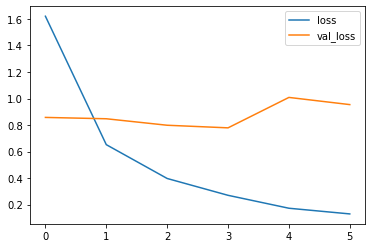

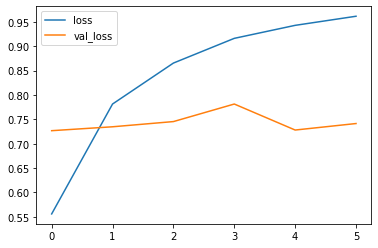

In [ ]:
plot_loss_curves(resnet_hist)

In [ ]:
## Creating our efficent net model

efficent_net = create_model(efficent_net_url)

In [ ]:
efficent_net.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [ ]:
efficent_net_history=efficent_net.fit(train_data_10_percent,
                 epochs=15,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='efficent_net')])

Saving Tensorboard to log dir : tensorflow_hub/efficent_net/20220711-050714
Epoch 1/15
375/375 [==============================] - 15s 30ms/step - loss: 1.1456 - accuracy: 0.6560 - val_loss: 0.6356 - val_accuracy: 0.8067
Epoch 2/15
375/375 [==============================] - 11s 29ms/step - loss: 0.4771 - accuracy: 0.8787 - val_loss: 0.4743 - val_accuracy: 0.8693
Epoch 3/15
375/375 [==============================] - 11s 29ms/step - loss: 0.3058 - accuracy: 0.9293 - val_loss: 0.4305 - val_accuracy: 0.8693
Epoch 4/15
375/375 [==============================] - 11s 29ms/step - loss: 0.2052 - accuracy: 0.9627 - val_loss: 0.4186 - val_accuracy: 0.8680
Epoch 5/15
375/375 [==============================] - 11s 29ms/step - loss: 0.1467 - accuracy: 0.9800 - val_loss: 0.4030 - val_accuracy: 0.8547
Epoch 6/15
375/375 [==============================] - 11s 29ms/step - loss: 0.1061 - accuracy: 0.9893 - val_loss: 0.4221 - val_accuracy: 0.8627
Epoch 7/15
375/375 [==============================] - 11s 29

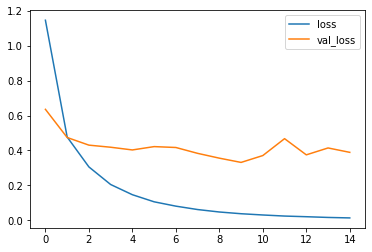

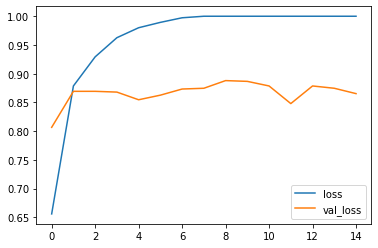

In [ ]:
plot_loss_curves(efficent_net_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [ ]:
efficent_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
